CSML1010_Group3_Course_Project_Data_Exploration - Group3: Paul Doucet, Jerry Khidaroo

In [42]:
# filter warnings on depreciation etc.
import warnings
warnings.filterwarnings("ignore")

In [43]:
# import pandas, numpy
import pandas as pd
import numpy as np

# adjust pandas display
pd.options.display.max_columns = 30
pd.options.display.max_rows = 100
pd.options.display.float_format = '{:.2f}'.format
pd.options.display.precision = 2
pd.options.display.max_colwidth = -1

In [44]:
# Import matplotlib and seaborn and adjust some defaults
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

from matplotlib import pyplot as plt
plt.rcParams['figure.dpi'] = 100

import seaborn as sns
sns.set_style("whitegrid")

Load Data

In [45]:
import sqlite3

sql = """
SELECT p.*
FROM posts_nlp p
"""

with sqlite3.connect('selfdialogs.db') as con:
    df = pd.read_sql_query(sql, con)

Data Exploration

In [46]:
# list column names and datatypes
df.dtypes

index                    int64  
id                       object 
Conversation             object 
Instruction_id           object 
service_type             object 
selfdialog_clean         object 
selfdialog_lemma         object 
selfdialog_nouns         object 
selfdialog_adjectives    object 
selfdialog_verbs         object 
selfdialog_nav           object 
no_tokens                float64
dtype: object

In [47]:
# select a sample of some data frame columns
df[['id', 'Conversation', 'Instruction_id','service_type']] \
  .sample(2, random_state=42)

,id,Conversation,Instruction_id,service_type
6482,dlg-d601e9c1-f9b4-4778-ae20-29f5ab6edd72,Hello can you please book a reservation at the crawling crab for tonight at 7:30 for 3 people There is no table available at that time how about 8:00 pm Ok That table is outside is that ok No that won’t work Ok is there another restaurant that you would like to try Yes how about the crying tree Same Time and party? Yes Ok I will book the table would you like the restaurant to send u a text confirmation Yes Ok what phone number 867 5309 Ok they will text u around 15 minutes before the table is ready to confirm the table Ok Do you want to order drinks to have ready when you arrive. Yes please order 2 glasses of red wine Ok they will have your drinks ready Ok To confirm I have a table for 3 ready at the crying tree for today at 7:30 wine will be ordered prior to arriving they will text to confirm is this correct Yes Ok your good to go,restaurant-table-2,restaurant
6872,dlg-e3797e80-a033-47d3-be9f-3235ea00f09c,"Hi, I would like for you to order a car for me From where would you like to leave? Bank of America Stadium, South Mint Street, Charlotte, NC And where will you be going? Romare Bearden Park, South Church Street, Charlotte, NC An UberX is $6.65 Is UberXL available? UberXL is available for 7.75. Are there any other options? Black is available for 15.00 and Black SUV is available for 25.00 I would like to book UberXL. You would like to book UberXL for 7.75? Yes, that's correct. Ok I am booking your UberXL now. Thank you. Do you have any other requests? How much was the total in the end? It was $7.75. When can I expect my UberXL to arrive? Your ride is on the way and you can check your status on your phone. Thanks!",uber-lyft-1,uber


In [48]:
# length of a dataframe
len(df)

7708

In [49]:
# number of values per column
df.count()

index                    7708
id                       7708
Conversation             7708
Instruction_id           7708
service_type             7708
selfdialog_clean         7708
selfdialog_lemma         7708
selfdialog_nouns         7708
selfdialog_adjectives    7708
selfdialog_verbs         7708
selfdialog_nav           7708
no_tokens                7708
dtype: int64

In [50]:
# size info, including memory consumption
df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7708 entries, 0 to 7707
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   index                  7708 non-null   int64  
 1   id                     7708 non-null   object 
 2   Conversation           7708 non-null   object 
 3   Instruction_id         7708 non-null   object 
 4   service_type           7708 non-null   object 
 5   selfdialog_clean       7708 non-null   object 
 6   selfdialog_lemma       7708 non-null   object 
 7   selfdialog_nouns       7708 non-null   object 
 8   selfdialog_adjectives  7708 non-null   object 
 9   selfdialog_verbs       7708 non-null   object 
 10  selfdialog_nav         7708 non-null   object 
 11  no_tokens              7708 non-null   float64
dtypes: float64(1), int64(1), object(10)
memory usage: 36.8 MB


Column Exploration

In [51]:
columns = [col for col in df.columns if not col.startswith('self')]
columns

['index', 'id', 'Conversation', 'Instruction_id', 'service_type', 'no_tokens']

In [52]:
# describe categorical columns of type np.object 
df[['service_type','Instruction_id']] \
  .describe(include=np.object) \
  .transpose()

,count,unique,top,freq
service_type,7708,6,pizza,1468
Instruction_id,7708,14,pizza-ordering-2,1211


In [53]:
df['Instruction_id'].value_counts()[:10]

pizza-ordering-2      1211
auto-repair-appt-1    1161
coffee-ordering-1     735 
restaurant-table-1    704 
movie-tickets-1       679 
uber-lyft-1           646 
coffee-ordering-2     641 
restaurant-table-2    494 
uber-lyft-2           452 
movie-tickets-2       377 
Name: Instruction_id, dtype: int64

In [54]:
# describe numerical columns
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
index,7708.00,3853.50,2225.25,0.00,1926.75,3853.50,5780.25,7707.00
no_tokens,7708.00,228.51,80.57,20.00,175.00,215.00,267.00,1336.00


Text Category Exploration

In [55]:
# group by service_type, count distinct Instruction_id
cat_df = df.groupby('service_type') \
           .agg({'Instruction_id': pd.Series.nunique,
                 'id': pd.Series.count}) \
           .rename(columns={'Instruction_id': 'num_Instruction_ids',
                            'id': 'num_posts'}) \
           .sort_values('num_Instruction_ids', ascending=False)
            
# show top 5 records
cat_df.head(5)

,num_Instruction_ids,num_posts
service_type,,
movie,4,1305
restaurant,3,1300
coffee,2,1376
pizza,2,1468
uber,2,1098


In [56]:
cat_df.describe()

,num_Instruction_ids,num_posts
count,6.00,6.00
mean,2.33,1284.67
std,1.03,136.19
min,1.00,1098.00
25%,2.00,1195.75
50%,2.00,1302.50
75%,2.75,1358.25
max,4.00,1468.00


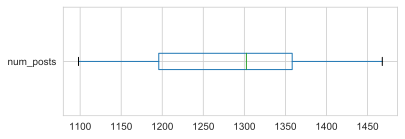

In [57]:
# horizontal boxplot of a dataframe column
cat_df[['num_posts']].plot(kind='box', vert=False, figsize=(6, 2));

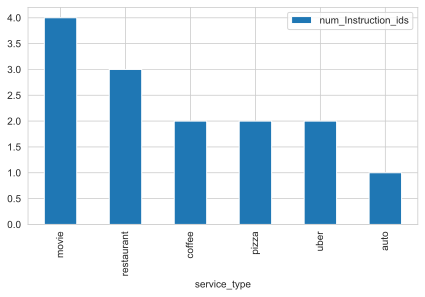

In [58]:
# bar chart of a dataframe column
cat_df[['num_Instruction_ids']].plot(kind='bar', figsize=(7,4));

Word Exploration

In [59]:
# create a data frame slice
sub_df = df[df['Instruction_id']=='movie-finder']

# sample cleaned text and tokens tagged as nouns
sub_df[['selfdialog_clean', 'selfdialog_nouns']].sample(2)

,selfdialog_clean,selfdialog_nouns
3601,"I need help finding a movie to watch. Okay. Are you wanting to rent a film or go to the theater? Rent a film. Okay. What genres do you like? I'm a fan of dramas and action films. Would you like a more recent film? Yeah, within the last ten years or so. Are there any actors or actresses you like? Uh, maybe Chris Pratt? Okay. I have three options for you from Chris Pratt. Guardians of the Galaxy, Passengers, and Jurassic World. Are any of those interesting? When did Passengers come out? Passengers is a 2016 American science fiction romance film directed by Morten Tyldum. Mm, I don't prefer romance. What were the other two you mentioned? Guardians of the Galaxy and Jurassic World. Can Jurassic World be found on Netflix? No, but it is available on YouTube from $2.99. Okay, thank you! You're welcome.",help movie film theater film genre fan drama action film film year actor actress chris pratt option chris pratt guardian galaxy passengers jurassic world passenger passenger science fiction romance film morten tyldum mm romance what guardian galaxy jurassic world jurassic world netflix youtube
5910,"I'm looking for a movie to watch tonight. Certainly, what genre are you looking for? Either action or comedy. Well theres a few movies that include both. Really? Which ones? Have you ever seen Rush Hour? No, I can't say that I have. Who stars in it. It has Jackie Chan and Chris Tucker. Does it have good reviews? Yes, it is considered a cult classic. Is it just one movie? No, Rush Hour as 2 sequels you can watch too. Are they as good as the first? Based on your preferences, I would say you wouldn't like them as much. Is there any dvd extras to Rush Hour? Yes, the dvd comes packed with extras. Great! Guess I know what I'm watching tonight. Thanks! You're welcome! Happy to help.",movie tonight genre action comedy movie one rush hour who jackie chan chris tucker review cult movie rush hour sequel preference dvd rush hour dvd extra what tonight thank


Create Token List

In [60]:
def my_tokenizer(text):
    return text.split() if text != None else []

In [61]:
# transform list of documents into a single list of tokens
tokens = sub_df.selfdialog_nouns.map(my_tokenizer).sum()

In [62]:
from collections import Counter

counter = Counter(tokens)
counter.most_common(20)

[('movie', 258),
 ('what', 82),
 ('something', 57),
 ('action', 37),
 ('comedy', 35),
 ('tonight', 30),
 ('one', 26),
 ('mood', 22),
 ('film', 22),
 ('time', 20),
 ('netflix', 20),
 ('genre', 19),
 ('star', 19),
 ('anything', 18),
 ('thank', 18),
 ('suggestion', 16),
 ('kind', 15),
 ('rating', 15),
 ('year', 14),
 ('preference', 14)]

In [63]:
df.service_type.unique()

array(['restaurant', 'movie', 'pizza', 'coffee', 'auto', 'uber'],
      dtype=object)

In [64]:
print([t[0] for t in counter.most_common(200)])  

['movie', 'what', 'something', 'action', 'comedy', 'tonight', 'one', 'mood', 'film', 'time', 'netflix', 'genre', 'star', 'anything', 'thank', 'suggestion', 'kind', 'rating', 'year', 'preference', 'wars', 'home', 'horror', 'actor', 'hour', 'ticket', 'assistant', 'problem', 'sci', 'fi', 'sir', 'list', 'who', 'theater', 'recommendation', 'day', 'lot', 'scifi', 'world', 'type', 'drama', 'imdb', 'fan', 'mind', 'tom', 'y', 'jedi', 'night', 'john', 'black', 'minute', 'trailer', 'episode', 'alien', 'romance', 'thriller', 'documentary', 'choice', 'place', 'help', 'nothing', 'book', 'amazon', 'name', 'return', 'wick', 'panther', 'popcorn', 'rush', 'director', 'blade', 'runner', 'release', 'master', 'jurassic', 'hanks', 'show', 'marvel', 'mission', 'classic', 'quiet', 'cast', 'box', 'review', 'showing', 'text', 'adam', 'option', 'way', 'adventure', 'empire', 'galaxy', 'war', 'rosemary', 'baby', 'demand', 'kung', 'fu', 'man', 'avengers', 'x', 'men', 'weather', 'fantasy', 'theme', 'space', 'hero', 

In [65]:
from spacy.lang.en.stop_words import STOP_WORDS

def remove_stopwords(tokens):
    """Remove stopwords from a list of tokens."""
    return [t for t in tokens if t not in STOP_WORDS]

# rebuild counter
counter = Counter(remove_stopwords(tokens))

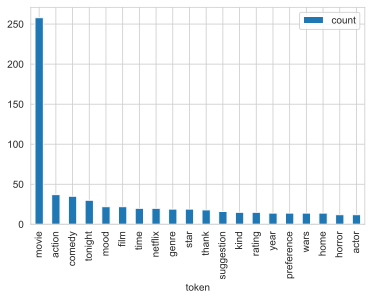

In [66]:
# convert list of tuples into data frame
freq_df = pd.DataFrame.from_records(counter.most_common(20),
                                    columns=['token', 'count'])

# create bar plot
freq_df.plot(kind='bar', x='token');

Exploring Word Clouds

In [67]:
%matplotlib inline
import matplotlib.pyplot as plt

In [68]:
from wordcloud import WordCloud

def wordcloud(counter):
    """A small wordloud wrapper"""
    wc = WordCloud(width=1200, height=800, 
                   background_color="white", 
                   max_words=200) 
    wc.generate_from_frequencies(counter)

    # Plot
    fig=plt.figure(figsize=(6, 4))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")
    plt.tight_layout(pad=0)
    plt.show()

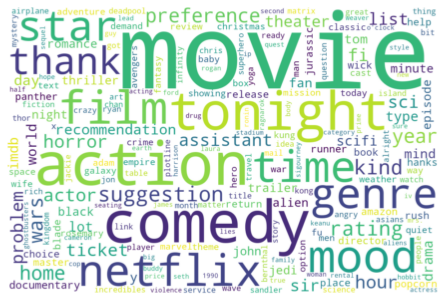

In [69]:
# create wordcloud
wordcloud(counter)

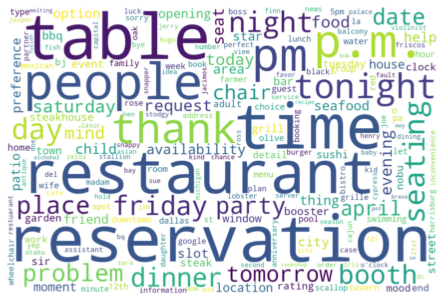

In [70]:
tokens2 = df[df['Instruction_id']=='restaurant-table-3'].selfdialog_nouns \
         .map(my_tokenizer).sum()

counter2 = Counter(remove_stopwords(tokens2))
wordcloud(counter2)

Exploring Complexity

In [71]:
df['no_tokens'] = df.selfdialog_lemma\
  .map(lambda l: 0 if l==None else len(l.split()))

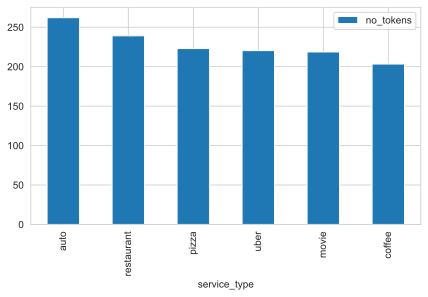

In [72]:
# mean number of tokens by category
df.groupby(['service_type']) \
  .agg({'no_tokens':'mean'}) \
  .sort_values(by='no_tokens', ascending=False) \
  .plot(kind='bar', figsize=(7,4));

In [73]:
# render plots as retina or png, because svg is very slow
%config InlineBackend.figure_format = 'retina'

import seaborn as sns

def multi_boxplot(data, x, y, ylim = None):
    '''Wrapper for sns boxplot with cut-off functionality'''
    # plt.figure(figsize=(30, 5))
    fig, ax = plt.subplots()
    plt.xticks(rotation=90) 

    # order boxplots by median
    ordered_values = data.groupby(x)[[y]] \
                         .median() \
                         .sort_values(y, ascending=False) \
                         .index
        
    sns.boxplot(x=x, y=y, data=data, palette='Set2', 
                order=ordered_values)

    fig.set_size_inches(11, 6)
    
    # cut-off y-axis at value ylim
    ax.set_ylim(0, ylim)

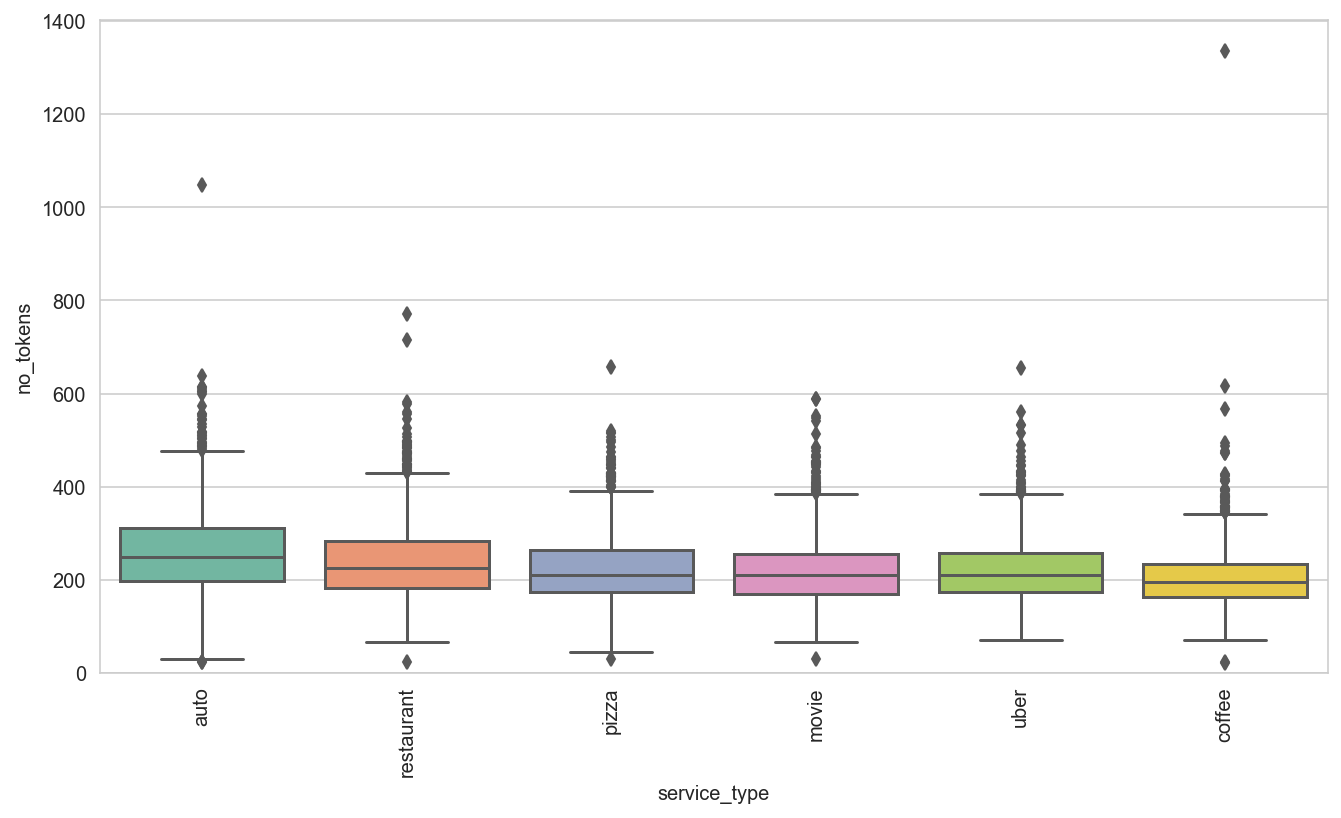

In [74]:
multi_boxplot(df, 'service_type', 'no_tokens');

In [75]:
# print text of outliers
df['selfdialog_lemma'][df.no_tokens > 1500]

Series([], Name: selfdialog_lemma, dtype: object)

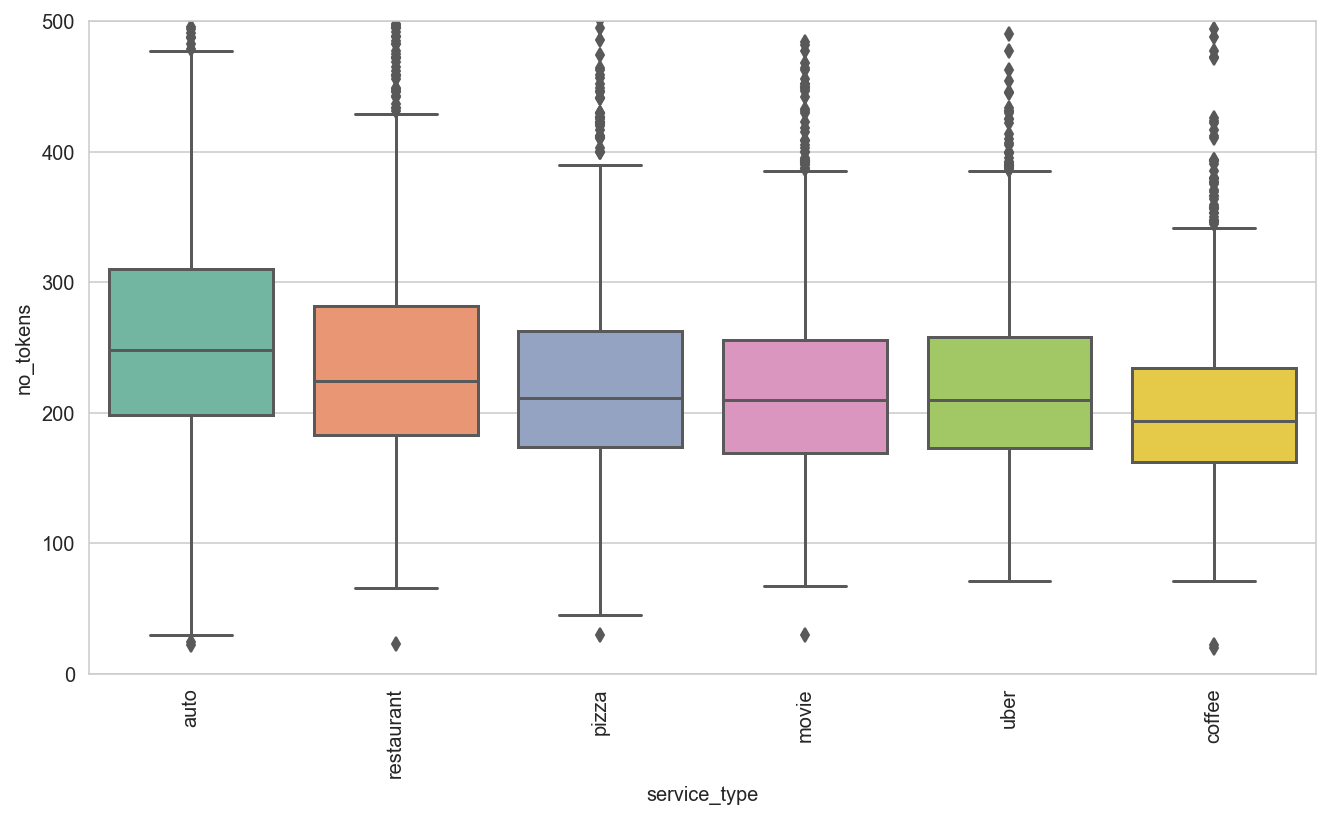

In [76]:
# cut-off diagram at y=500
multi_boxplot(df, 'service_type', 'no_tokens', ylim=500)

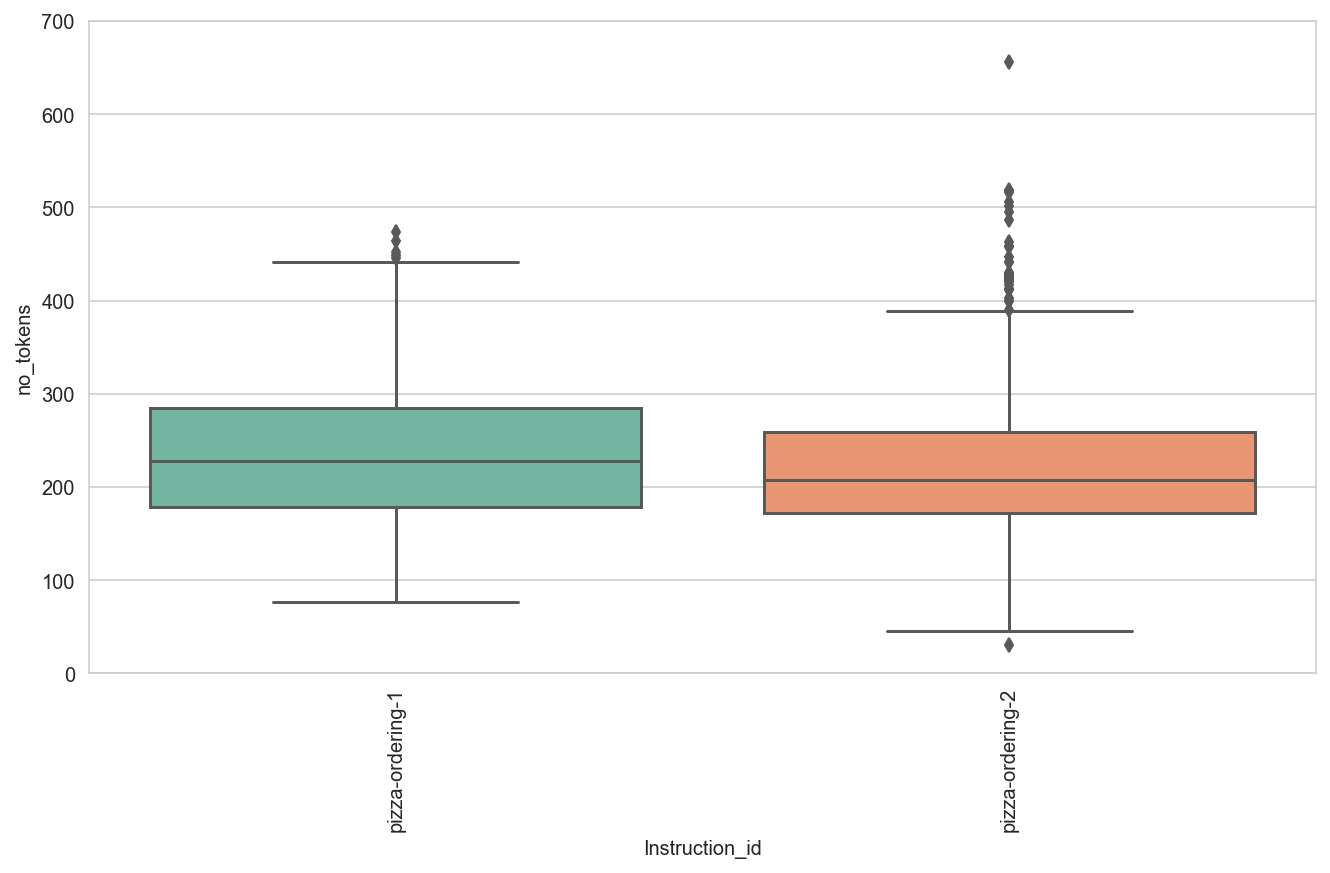

In [77]:
# comparing Instruction_id within a single service_type
multi_boxplot(df[df.service_type=='pizza'], 
              'Instruction_id', 'no_tokens', ylim=700)